In [38]:
#!git clone https://github.com/proshian/DNN_course_ITMO_2022.git
%cd /kaggle/working/DNN_course_ITMO_2022/lab1/pytorch_implementations

/kaggle/working/DNN_course_ITMO_2022/lab1/pytorch_implementations


# Лабараторная работа 1
Вариант 11

#### **Цель работы:**
Научиться реализовывать один из алгоритмов глубокого обучения.

#### **Задание:**
1. Скачайте датасет [CarDatasets](https://drive.google.com/drive/folders/1pkudEBabqbXMxRTgfGQs3e0VqfTjtqWU)
2. Реализуйте ResNet-101 с оптимизатором [Adabound](https://arxiv.org/abs/1902.09843v1) с использованием
Numpy и с **Torch**/Tensorflow/Jax
3. Оцените качество модели на тесте и сравните быстродействие
реализованных вариантов.
4. Запустить обучение на классическом Adam и сравнить сходимость
результатов с вариантом задания.
5. Сделайте отчёт в виде readme на GitHub, там же должен быть выложен
исходный код.

#### **Отчёт должен содержать следующие пункты:**
1. Теоретическая база
2. Описание разработанной системы (алгоритмы, принципы работы,
архитектура)
3. Результаты работы и тестирования системы (скриншоты, изображения,
графики, закономерности)
4. Выводы по работе
5. Использованные источники

План:
1. Получить Dataloader, возвращающий обрезанное в соответствии с annotations изображение, убедиться, что тензор корректно конвертируется в numpy
2. Загрузить и запустить готовый resnet101. Хотя, скорее всего, это не пригодится. Запустить на нём обучение
3. Имплементировать на torch
4. Имплементирвать на numpy


* Resnet обязательно 224x224?
* Обязательно квадратные картинки?
* Лучше машина целиком в низком разрешении и мб сжатая по горизонтали или фрагмент машины?
* Rgb или gray-scale?


In [2]:
%cd /kaggle/working/DNN_course_ITMO_2022/lab1/pytorch_implementations

/kaggle/working/DNN_course_ITMO_2022/lab1/pytorch_implementations


В датасете есть одноканальные изображения

In [8]:
import os
from collections import Counter
import pickle


import scipy.io
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score


from resnet import resnet101

In [9]:
torchvision.datasets.StanfordCars('.', split = "train", download = True)
torchvision.datasets.StanfordCars('.', split = "test", download = True)

Dataset StanfordCars
    Number of datapoints: 8041
    Root location: .

In [8]:
# class ResizeToNeededHeight(torch.nn.Module):
    
#     def __init__(self, needed_height, interpolation=torchvision.transforms.InterpolationMode.BILINEAR, max_size=None, antialias=None):
#         super().__init__()
#         #_log_api_usage_once(self)
        
#         self.needed_height = needed_height
#         self.max_size = max_size

#         self.interpolation = interpolation
#         self.antialias = antialias

#     def forward(self, img):
#         """
#         Args:
#             img (PIL Image or Tensor): Image to be scaled.
#         Returns:
#             PIL Image or Tensor: Rescaled image.
#         """
#         w, h = img.size
#         size = (self.needed_height, round(w / h * self.needed_height))
#         return torchvision.transforms.functional.resize(
#             img, size, self.interpolation, self.max_size, self.antialias)

#     def __repr__(self) -> str:
#         detail = f"(needed_height={self.needed_height}, interpolation={self.interpolation.value}, max_size={self.max_size}, antialias={self.antialias})"
#         return f"{self.__class__.__name__}{detail}"


In [9]:

# class AddGaussianNoise(object):
#     def __init__(self, mean=0., std=1.):
#         self.std = std
#         self.mean = mean
        
#     def __call__(self, tensor):
#         return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
#     def __repr__(self):
#         return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


"\nclass AddGaussianNoise(object):\n    def __init__(self, mean=0., std=1.):\n        self.std = std\n        self.mean = mean\n        \n    def __call__(self, tensor):\n        return tensor + torch.randn(tensor.size()) * self.std + self.mean\n    \n    def __repr__(self):\n        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)\n"

In [10]:
class CarsDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, classes = None, img_folder_path = '',
                 transform=None, target_transform=None):
        
        self.annotations = annotations
        self.transform = transform
        self.target_transform = target_transform
        self.img_folder_path = img_folder_path
        self.classes = classes

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        x1, y1, x2, y2, class_number, img_name = self.annotations[idx]
        uncropped_image = torchvision.io.read_image(
            os.path.join(self.img_folder_path, img_name))
        image = uncropped_image[:, y1:y2, x1:x2]
        #image = image.to(dtype = torch.float32)
        if image.shape[-3] == 1:
            image = torch.cat([image, image, image], dim=0)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_number = self.target_transform(class_number)
        return image, class_number - 1 # В аннтоациях числа от 1 до 196
    
# class CarsDatasetWithoutLabels(CarsDataset):
#     def __getitem__(self, idx):
#         x1, y1, x2, y2, img_name = self.annotations[idx]
#         uncropped_image = torchvision.io.read_image(
#             os.path.join(self.img_folder_path, img_name))
#         image = uncropped_image[:, y1:y2, x1:x2]
#         # image = image.to(dtype = torch.float32)
#         if self.transform:
#             image = self.transform(image)
#         return image


In [11]:
dataset_loc = r"./stanford_cars"

# annos['train'] и annos['val'] содержат x1, y1, x2, y2, class, img_name для каждого изображения датасета.
# class_names по индексу, равному числовому лейблу возвращает соответствующее имя класса
annos = dict()
annos['train'] = scipy.io.loadmat(
    os.path.join(r"./stanford_cars/devkit", 'cars_train_annos.mat'),
    squeeze_me = True
)['annotations']
annos['val'] = scipy.io.loadmat(
    os.path.join(dataset_loc, 'cars_test_annos_withlabels.mat'),
    squeeze_me = True
)['annotations']


class_names = scipy.io.loadmat(
    os.path.join(r"./stanford_cars/devkit", 'cars_meta.mat'),
    squeeze_me = True
)['class_names']

normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = dict()
data_transforms['train'] = (
    torchvision.transforms.Compose([
        # AddGaussianNoise(0.0,0.0000001),
        torchvision.transforms.ToPILImage(),
        #ResizeToNeededHeight(180),
        torchvision.transforms.RandomRotation((-13, 13)), # if you do rotation afterwords the quality will be worse
        torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
        #torchvision.transforms.RandomCrop(224, pad_if_needed=True),
        # torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.Resize((96, 96)),
        torchvision.transforms.RandomHorizontalFlip(p = 0.5),
        # torchvision.transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor(),
        # normalize
    ]))

data_transforms['val'] = (
    torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        # torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.Resize((96, 96)),
        #ResizeToNeededHeight(180),
        #torchvision.transforms.RandomCrop(224, pad_if_needed=True),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor(),
        # normalize
    ]))


folder_names = {
    "train": 'cars_train',
    "val": 'cars_test'
}


datasets = {
    phase: CarsDataset(annos[phase], img_folder_path = os.path.join(dataset_loc, folder_names[phase]), 
                       transform = data_transforms[phase], classes = class_names)
    for phase in ['train', 'val']
}



dataloaders = {
    'train':
    torch.utils.data.DataLoader(datasets['train'],
                                batch_size=200,# 512 - много # раньше 400 было норм
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'val':
    torch.utils.data.DataLoader(datasets['val'],
                                batch_size=200,
                                shuffle=False,
                                num_workers=0),  # for Kaggle
}

In [12]:
len(datasets['train']), len(datasets['val'])

(8144, 8041)

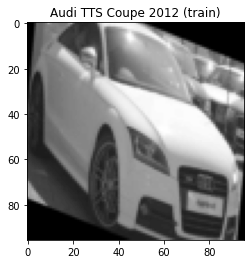

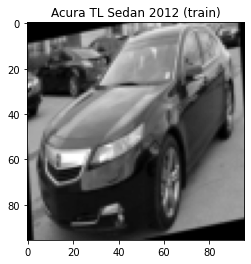

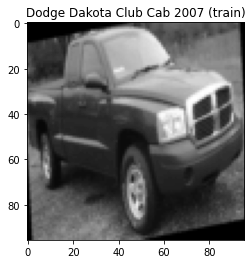

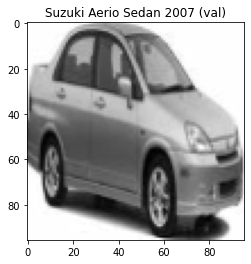

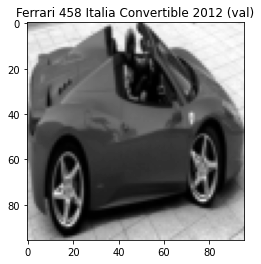

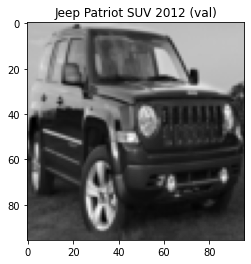

In [13]:
for phase in ['train', 'val']:
    for i in range(3):
        image, class_number = datasets[phase][i]
        plt.imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
        plt.title(datasets[phase].classes[class_number]+ f' ({phase})')
        plt.show()

In [28]:
# This cell proves that there are imges with one channel

# min_h = 10000
# indexes_less_than_3_channels = []
# for i, (tensor, label) in enumerate(dataset_with_labels):
#     c, h, w = tensor.shape
#     min_h = min(h, min_h)
#     if c < 3:
#         indexes_less_than_3_channels.append(i)
#         if c != 1:
#             print(f"unexpected_number_of_channels: {c}")
# print(f"min_h = {min_h}")
# print(indexes_less_than_3_channels)

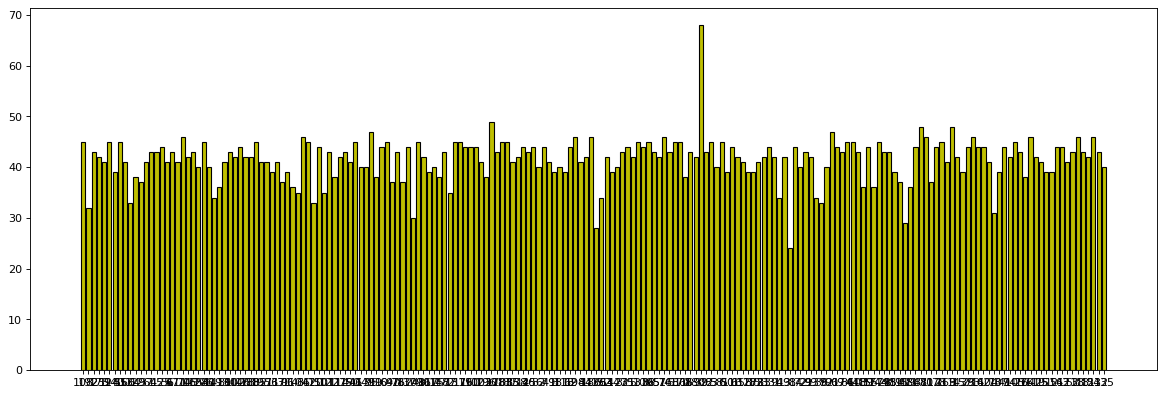

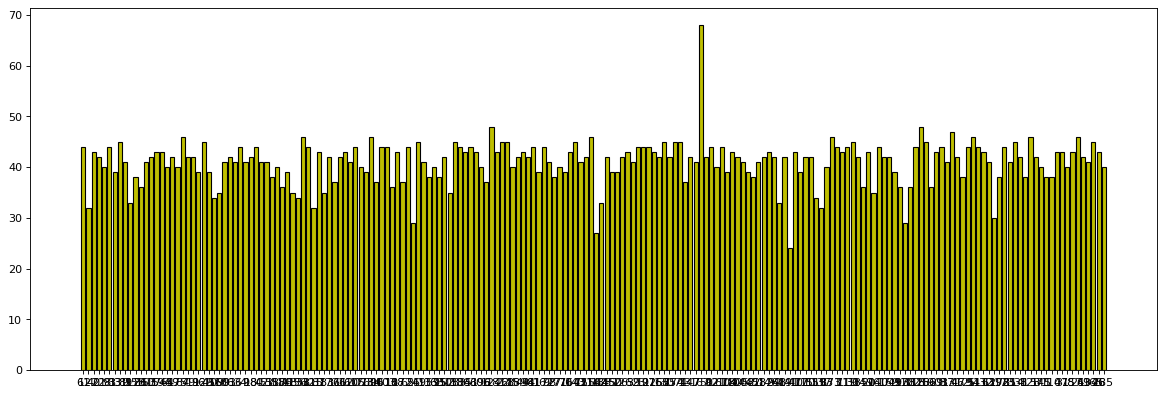

In [12]:
from collections import Counter

classes_train = [line[4] for line in annos['train']]
classes_val = [line[4] for line in annos['val']]

train_classes_count_dict = dict(Counter(classes_train))
val_classes_count_dict = dict(Counter(classes_val))
    
    
for value_counts in [train_classes_count_dict, val_classes_count_dict]:
    plt.figure(figsize=(40, 6), dpi=80)

    plt.subplot(1, 2, 1)
    plt.bar(
        x = value_counts.keys(),
        height = value_counts.values(),
        width = 0.8,
        align = 'center',
        color='y',
        edgecolor='k',
        tick_label=list(range(1, 197)),
        label = list(datasets['val'].classes))

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
n_classes = len(datasets['train'].classes)
n_classes

196

In [16]:
# !nvidia-smi

In [ ]:
# adam_my_resnet_005 = torch.optim.Adam(my_resnet101.parameters(), lr = 0.05)
# lr = 0.01 для начала гораздо лучше, чем 0.001
# 0.05 > 0.01 > 0.001

In [16]:
def train_model(model, criterion, optimizer, num_epochs=3, phases = ['train', 'val'], history = None):
    test_loss_history = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)
    
        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            all_true_labels = []
            all_preds = []
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                all_true_labels.extend(labels.tolist())
                all_preds.extend(preds.tolist())

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.item() / len(datasets[phase])
            epoch_f_score = f1_score(all_true_labels, all_preds, average = 'macro')
            
            if history is not None:
                history[phase]["f_score"].append(epoch_f_score)
                history[phase]["loss"].append(epoch_loss)
                history[phase]["accuracy"].append(epoch_acc)

            # print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}")
            print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}, accuracy: {epoch_acc}")

In [17]:
def train_and_val(model, optimizer, history, experiment_name, n_train_epoches_in_iter = 4, n_iters = 2):
    criterion = torch.nn.CrossEntropyLoss()
    for i in range(n_iters):
        print(i)
        print("----------")
        train_model(model, criterion, optimizer, num_epochs=n_train_epoches_in_iter, phases = ['train'], history = history)
        
        n_epoches = len(history['train']['loss'])
        weights_name = f'{experiment_name}_{n_epoches}.h5'
        # weights_loc = os.path.join('.','pytorch_implementations','weights')
        weights_loc = '.'
        weights_path = os.path.join(weights_loc, weights_name)
        torch.save(model.state_dict(), weights_path)
        
        train_model(model, criterion, optimizer, num_epochs=1, phases = ['val'], history = history)

In [18]:
def plot_history(history1: dict, history2: dict):
    phases = ['train', 'val']
    fig, axs = plt.subplots(len(phases), len(history1['train']))

    fig.set_figheight(10)
    fig.set_figwidth(20)


    for phase_index, phase in enumerate(['train', 'val']):
        for key_index, (key, value) in enumerate(history1[phase].items()):
            axs[phase_index][key_index].plot(value)
            axs[phase_index][key_index].plot(history2[phase][key])
            axs[phase_index][key_index].set_title(f"{phase} {key}")
    plt.show()


In [108]:
my_resnet101 = resnet101(n_classes, 1).to(device)
weights_path = './my_resnet101_initialization.h5'
#torch.save(my_resnet101.state_dict(), './my_resnet101_initialization.h5')
my_resnet101.load_state_dict(torch.load(weights_path))

adabound_my_resnet = AdaBound(my_resnet101.parameters(), lr = 0.002)

my_resnet_history_AdaBound = {
    "train": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    },
    "val": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    }
} 

experiment_name = "my_torch_resnet_adabound"

In [109]:
train_and_val(my_resnet101, adabound_my_resnet, my_resnet_history_AdaBound, experiment_name, n_train_epoches_in_iter = 4, n_iters = 10)

0
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.2791, f_score: 0.0004, accuracy: 0.005648330058939097
Epoch 2/4
----------


100%|██████████| 41/41 [03:05<00:00,  4.51s/it]


train loss: 5.2773, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 3/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 5.2768, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.2762, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 5.2752, f_score: 0.0001, accuracy: 0.008456659619450317
1
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 5.2757, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 2/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 5.2753, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 3/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 5.2748, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 4/4
----------


100%|██████████| 41/41 [03:06<00:00,  4.54s/it]


train loss: 5.2746, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 1/1
----------


100%|██████████| 41/41 [01:44<00:00,  2.54s/it]


val loss: 5.2737, f_score: 0.0001, accuracy: 0.008456659619450317
2
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:06<00:00,  4.56s/it]


train loss: 5.2742, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 5.2740, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 5.2737, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 4/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 5.2736, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.49s/it]


val loss: 5.2729, f_score: 0.0001, accuracy: 0.008456659619450317
3
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.2735, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.2733, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 5.2731, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.44s/it]


train loss: 5.2731, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.49s/it]


val loss: 5.2724, f_score: 0.0001, accuracy: 0.008456659619450317
4
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.2727, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.2729, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.2727, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.2726, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.49s/it]


val loss: 5.2721, f_score: 0.0001, accuracy: 0.008456659619450317
5
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.2726, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 2/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 5.2724, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 5.2723, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.2722, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.50s/it]


val loss: 5.2718, f_score: 0.0001, accuracy: 0.008456659619450317
6
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 5.2720, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.2718, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 5.2722, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 4/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.43s/it]


train loss: 5.2719, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.47s/it]


val loss: 5.2715, f_score: 0.0001, accuracy: 0.008456659619450317
7
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.42s/it]


train loss: 5.2716, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.44s/it]


train loss: 5.2718, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 3/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.42s/it]


train loss: 5.2715, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 4/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.43s/it]


train loss: 5.2714, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 5.2712, f_score: 0.0001, accuracy: 0.008456659619450317
8
----------
Epoch 1/4
----------


 24%|██▍       | 10/41 [00:48<02:30,  4.85s/it]


KeyboardInterrupt: 

In [110]:
with open(f'{experiment_name}_history.pickle', 'wb') as f:
    pickle.dump(my_resnet_history_AdaBound, f)

with open(f'{experiment_name}_history.pickle', 'rb') as f:
    my_resnet_history_AdaBound = pickle.load(f)

adabound_optimizer_state_path = "./adabound_optimizer_state_my_resnet_101_40_epochs.h5"
torch.save(adabound_my_resnet.state_dict(), adabound_optimizer_state_path)

In [36]:
# experiment_name = "my_torch_resnet_adabound"
# with open(f'{experiment_name}_history.pickle', 'rb') as f:
#     my_resnet_history_AdaBound = pickle.load(f)

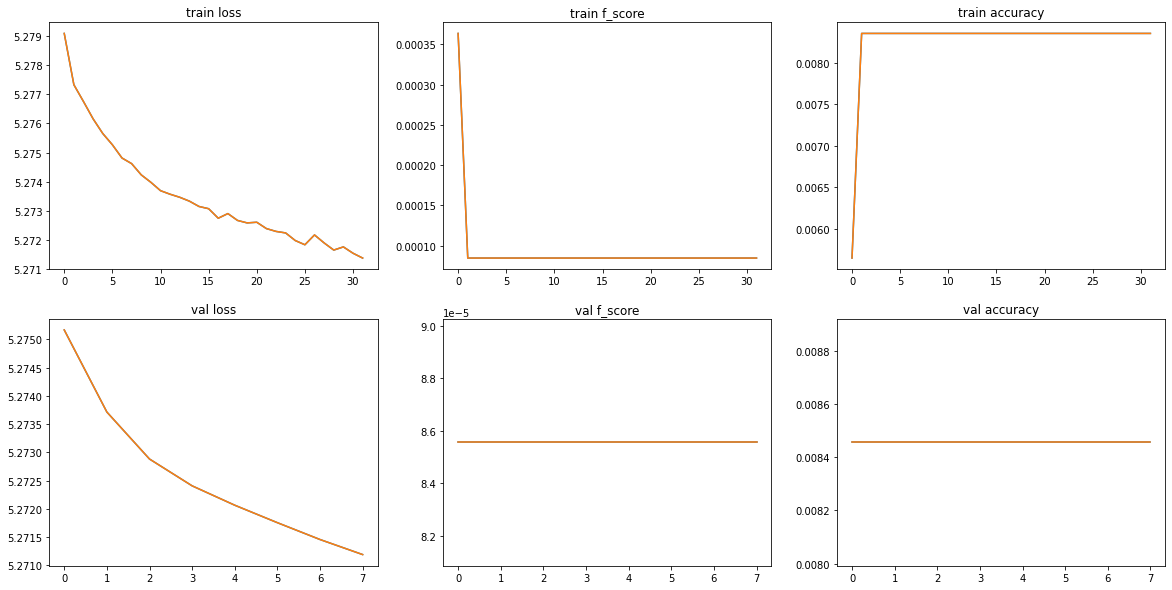

In [37]:
plot_history(my_resnet_history_AdaBound, my_resnet_history_AdaBound)

In [99]:
my_resnet101 = resnet101(n_classes, 1).to(device)
weights_path = './my_resnet101_initialization.h5'
#torch.save(my_resnet101.state_dict(), './my_resnet101_initialization.h5')
my_resnet101.load_state_dict(torch.load(weights_path))

adam_my_resnet = torch.optim.Adam(my_resnet101.parameters(), lr = 0.002)

my_resnet_history_Adam = {
    "train": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    },
    "val": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    }
} 

experiment_name = "my_torch_resnet_adam"

In [100]:
train_and_val(my_resnet101, adam_my_resnet, my_resnet_history_Adam, experiment_name, n_train_epoches_in_iter = 4, n_iters = 10)

0
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.42s/it]


train loss: 11.7567, f_score: 0.0003, accuracy: 0.005279960707269155
Epoch 2/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.43s/it]


train loss: 5.2776, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 3/4
----------


100%|██████████| 41/41 [03:00<00:00,  4.41s/it]


train loss: 5.2770, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 4/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.38s/it]


train loss: 5.3614, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.47s/it]


val loss: 5.2755, f_score: 0.0001, accuracy: 0.008456659619450317
1
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:00<00:00,  4.40s/it]


train loss: 5.2772, f_score: 0.0002, accuracy: 0.007735756385068762
Epoch 2/4
----------


100%|██████████| 41/41 [03:00<00:00,  4.40s/it]


train loss: 5.2798, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 3/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.38s/it]


train loss: 5.2755, f_score: 0.0003, accuracy: 0.008226915520628684
Epoch 4/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.39s/it]


train loss: 5.2753, f_score: 0.0003, accuracy: 0.008349705304518664
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 5.2743, f_score: 0.0001, accuracy: 0.004974505658500186
2
----------
Epoch 1/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.38s/it]


train loss: 5.2751, f_score: 0.0002, accuracy: 0.007612966601178782
Epoch 2/4
----------


100%|██████████| 41/41 [03:00<00:00,  4.41s/it]


train loss: 5.2746, f_score: 0.0002, accuracy: 0.008349705304518664
Epoch 3/4
----------


100%|██████████| 41/41 [03:00<00:00,  4.40s/it]


train loss: 5.2740, f_score: 0.0001, accuracy: 0.0073673870333988214
Epoch 4/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.37s/it]


train loss: 5.2715, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.49s/it]


val loss: 5.2682, f_score: 0.0001, accuracy: 0.008456659619450317
3
----------
Epoch 1/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.39s/it]


train loss: 5.2754, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 2/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.38s/it]


train loss: 5.2746, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 3/4
----------


100%|██████████| 41/41 [03:00<00:00,  4.40s/it]


train loss: 5.2744, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 4/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.37s/it]


train loss: 5.2734, f_score: 0.0001, accuracy: 0.008349705304518664
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 5.2719, f_score: 0.0001, accuracy: 0.008456659619450317
4
----------
Epoch 1/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.38s/it]


train loss: 5.2722, f_score: 0.0001, accuracy: 0.008226915520628684
Epoch 2/4
----------


100%|██████████| 41/41 [03:00<00:00,  4.39s/it]


train loss: 5.2598, f_score: 0.0006, accuracy: 0.008349705304518664
Epoch 3/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.39s/it]


train loss: 5.2306, f_score: 0.0006, accuracy: 0.009209233791748527
Epoch 4/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.38s/it]


train loss: 5.2065, f_score: 0.0014, accuracy: 0.011542239685658153
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 5.1783, f_score: 0.0016, accuracy: 0.011317000373087924
5
----------
Epoch 1/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.37s/it]


train loss: 5.1893, f_score: 0.0029, accuracy: 0.012647347740667976
Epoch 2/4
----------


100%|██████████| 41/41 [03:00<00:00,  4.40s/it]


train loss: 5.1586, f_score: 0.0028, accuracy: 0.013998035363457761
Epoch 3/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.39s/it]


train loss: 5.1277, f_score: 0.0045, accuracy: 0.015471512770137525
Epoch 4/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.37s/it]


train loss: 5.1132, f_score: 0.0062, accuracy: 0.017804518664047152
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 5.1347, f_score: 0.0051, accuracy: 0.016042780748663103
6
----------
Epoch 1/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.37s/it]


train loss: 5.0851, f_score: 0.0071, accuracy: 0.018050098231827114
Epoch 2/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.38s/it]


train loss: 5.0447, f_score: 0.0083, accuracy: 0.021611001964636542
Epoch 3/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.39s/it]


train loss: 5.0231, f_score: 0.0094, accuracy: 0.022593320235756387
Epoch 4/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.37s/it]


train loss: 4.9922, f_score: 0.0101, accuracy: 0.022593320235756387
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 4.9836, f_score: 0.0106, accuracy: 0.027857231687601045
7
----------
Epoch 1/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.37s/it]


train loss: 4.9645, f_score: 0.0113, accuracy: 0.023207269155206288
Epoch 2/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.38s/it]


train loss: 4.8973, f_score: 0.0148, accuracy: 0.02775049115913556
Epoch 3/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.38s/it]


train loss: 4.8788, f_score: 0.0187, accuracy: 0.033030451866404714
Epoch 4/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.38s/it]


train loss: 4.8364, f_score: 0.0199, accuracy: 0.03266208251473477
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 4.8582, f_score: 0.0192, accuracy: 0.03444845168511379
8
----------
Epoch 1/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.38s/it]


train loss: 4.7903, f_score: 0.0203, accuracy: 0.03401277013752456
Epoch 2/4
----------


100%|██████████| 41/41 [03:00<00:00,  4.40s/it]


train loss: 4.7725, f_score: 0.0233, accuracy: 0.035731827111984284
Epoch 3/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.38s/it]


train loss: 4.7134, f_score: 0.0279, accuracy: 0.04015225933202358
Epoch 4/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.37s/it]


train loss: 4.7094, f_score: 0.0270, accuracy: 0.03953831041257368
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 4.7113, f_score: 0.0235, accuracy: 0.040169133192389
9
----------
Epoch 1/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.38s/it]


train loss: 4.6513, f_score: 0.0354, accuracy: 0.047274066797642435
Epoch 2/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.38s/it]


train loss: 4.6178, f_score: 0.0360, accuracy: 0.04678290766208251
Epoch 3/4
----------


100%|██████████| 41/41 [02:59<00:00,  4.38s/it]


train loss: 4.5799, f_score: 0.0363, accuracy: 0.048010805500982315
Epoch 4/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.43s/it]


train loss: 4.5484, f_score: 0.0395, accuracy: 0.05108055009823183
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.50s/it]

val loss: 4.6382, f_score: 0.0364, accuracy: 0.05235667205571446


In [101]:
with open(f'{experiment_name}_history.pickle', 'wb') as f:
    pickle.dump(my_resnet_history_Adam, f)

with open(f'{experiment_name}_history.pickle', 'rb') as f:
    my_resnet_history_Adam = pickle.load(f)

adam_optimizer_state_path = "./adam_optimizer_state_my_resnet_101_40_epochs.h5"
torch.save(adam_my_resnet.state_dict(), adam_optimizer_state_path)

In [34]:
experiment_name = "my_torch_resnet_adam"
with open(f'{experiment_name}_history.pickle', 'rb') as f:
    my_resnet_history_Adam = pickle.load(f)

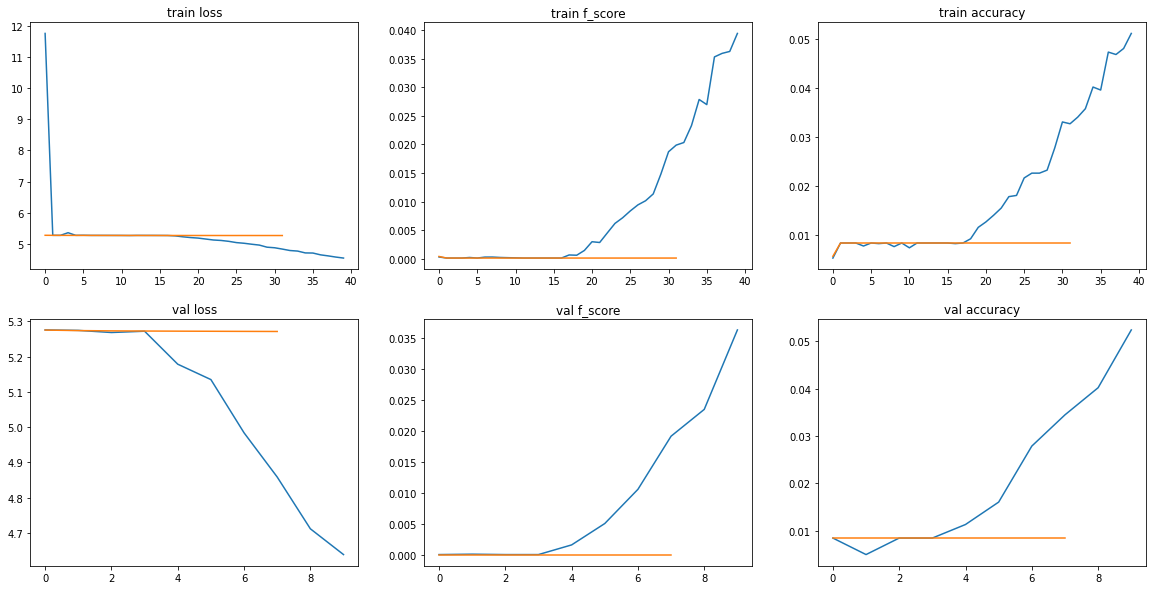

In [38]:
plot_history(my_resnet_history_Adam, my_resnet_history_AdaBound)

In [43]:
# Pytorch official implementation + Adabound

torch_resnet101 = resnet101_torch(n_classes).to(device)

adabound_torch = AdaBound(torch_resnet101.parameters(), lr = 0.001)

torch_history_AdaBound = {
    "train": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    },
    "val": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    }
} 

experiment_name = "torch_resnet_adabound"

In [50]:
train_and_val(torch_resnet101, adabound_torch, torch_history_AdaBound, experiment_name, n_train_epoches_in_iter = 4, n_iters = 10)

0
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:05<00:00,  4.52s/it]


train loss: 5.3218, f_score: 0.0004, accuracy: 0.007981335952848723
Epoch 2/4
----------


100%|██████████| 41/41 [03:05<00:00,  4.52s/it]


train loss: 5.3285, f_score: 0.0006, accuracy: 0.007858546168958742
Epoch 3/4
----------


100%|██████████| 41/41 [03:05<00:00,  4.53s/it]


train loss: 5.3085, f_score: 0.0007, accuracy: 0.009209233791748527
Epoch 4/4
----------


100%|██████████| 41/41 [03:06<00:00,  4.54s/it]


train loss: 5.2848, f_score: 0.0010, accuracy: 0.009823182711198428
Epoch 1/1
----------


100%|██████████| 41/41 [01:43<00:00,  2.52s/it]


val loss: 5.2287, f_score: 0.0007, accuracy: 0.00932719810968785
1
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 5.2589, f_score: 0.0016, accuracy: 0.010805500982318271
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.2397, f_score: 0.0014, accuracy: 0.012647347740667976
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.2091, f_score: 0.0021, accuracy: 0.011296660117878193
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 5.1924, f_score: 0.0024, accuracy: 0.01068271119842829
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.50s/it]


val loss: 5.1925, f_score: 0.0040, accuracy: 0.013928615843800523
2
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 5.1642, f_score: 0.0030, accuracy: 0.011665029469548133
Epoch 2/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 5.1551, f_score: 0.0040, accuracy: 0.012770137524557957
Epoch 3/4
----------


100%|██████████| 41/41 [03:05<00:00,  4.53s/it]


train loss: 5.1227, f_score: 0.0052, accuracy: 0.016085461689587428
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.0938, f_score: 0.0060, accuracy: 0.01731335952848723
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.51s/it]


val loss: 5.2055, f_score: 0.0051, accuracy: 0.018281308294988186
3
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.0649, f_score: 0.0067, accuracy: 0.01706777996070727
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 5.0272, f_score: 0.0105, accuracy: 0.023084479371316306
Epoch 3/4
----------


100%|██████████| 41/41 [03:05<00:00,  4.52s/it]


train loss: 5.0048, f_score: 0.0095, accuracy: 0.022961689587426327
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 4.9598, f_score: 0.0106, accuracy: 0.02443516699410609
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 4.9687, f_score: 0.0119, accuracy: 0.025991792065663474
4
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 4.9198, f_score: 0.0130, accuracy: 0.02431237721021611
Epoch 2/4
----------


100%|██████████| 41/41 [03:05<00:00,  4.52s/it]


train loss: 4.8765, f_score: 0.0168, accuracy: 0.03180255402750491
Epoch 3/4
----------


100%|██████████| 41/41 [03:05<00:00,  4.51s/it]


train loss: 4.8226, f_score: 0.0197, accuracy: 0.035731827111984284
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 4.7630, f_score: 0.0204, accuracy: 0.03511787819253438
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.49s/it]


val loss: 5.2617, f_score: 0.0167, accuracy: 0.03171247357293869
5
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:05<00:00,  4.52s/it]


train loss: 4.6765, f_score: 0.0265, accuracy: 0.0406434184675835
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 4.5755, f_score: 0.0371, accuracy: 0.05255402750491159
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 4.4859, f_score: 0.0416, accuracy: 0.0550098231827112
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 4.3684, f_score: 0.0485, accuracy: 0.06446463654223969
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.50s/it]


val loss: 4.4480, f_score: 0.0415, accuracy: 0.06429548563611491
6
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 4.2358, f_score: 0.0570, accuracy: 0.07269155206286837
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 4.1379, f_score: 0.0695, accuracy: 0.08521611001964637
Epoch 3/4
----------


100%|██████████| 41/41 [03:05<00:00,  4.53s/it]


train loss: 4.0411, f_score: 0.0804, accuracy: 0.09565324165029469
Epoch 4/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.49s/it]


train loss: 3.8671, f_score: 0.0961, accuracy: 0.11358055009823183
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.51s/it]


val loss: 4.0829, f_score: 0.0801, accuracy: 0.0983708493968412
7
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 3.7961, f_score: 0.1068, accuracy: 0.12352652259332024
Epoch 2/4
----------


100%|██████████| 41/41 [03:06<00:00,  4.55s/it]


train loss: 3.6734, f_score: 0.1266, accuracy: 0.1407170923379175
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 3.5387, f_score: 0.1411, accuracy: 0.15643418467583498
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 3.4025, f_score: 0.1603, accuracy: 0.17423870333988212
Epoch 1/1
----------


100%|██████████| 41/41 [01:43<00:00,  2.51s/it]


val loss: 4.0020, f_score: 0.1002, accuracy: 0.12398955353811715
8
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 3.3147, f_score: 0.1808, accuracy: 0.1942534381139489
Epoch 2/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 3.2173, f_score: 0.1916, accuracy: 0.20346267190569745
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 3.0318, f_score: 0.2236, accuracy: 0.2337917485265226
Epoch 4/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.51s/it]


train loss: 2.9570, f_score: 0.2381, accuracy: 0.24877210216110018
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.49s/it]


val loss: 4.3113, f_score: 0.1417, accuracy: 0.1570700161671434
9
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.50s/it]


train loss: 2.8414, f_score: 0.2549, accuracy: 0.2655943025540275
Epoch 2/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 2.7369, f_score: 0.2783, accuracy: 0.2881876227897839
Epoch 3/4
----------


100%|██████████| 41/41 [03:04<00:00,  4.49s/it]


train loss: 2.5759, f_score: 0.3045, accuracy: 0.31409626719056977
Epoch 4/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 2.4329, f_score: 0.3403, accuracy: 0.34921414538310414
Epoch 1/1
----------


100%|██████████| 41/41 [01:42<00:00,  2.49s/it]

val loss: 3.7672, f_score: 0.1610, accuracy: 0.1840567093645069


In [51]:
with open('torch_history_AdaBound.pickle', 'wb') as f:
    pickle.dump(torch_history_AdaBound, f)

with open('torch_history_AdaBound.pickle', 'rb') as f:
    torch_history_AdaBound = pickle.load(f)

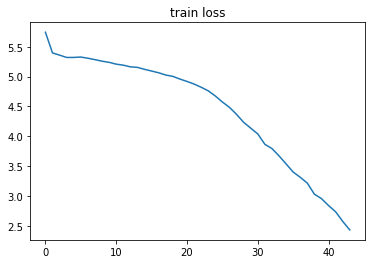

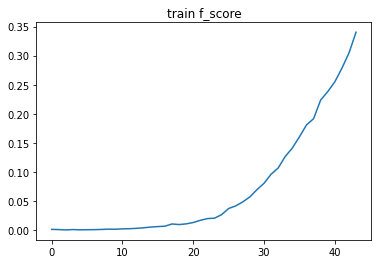

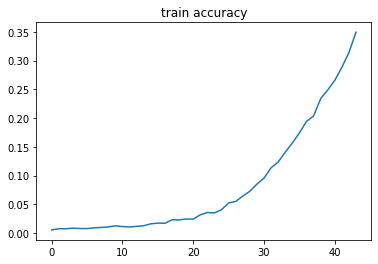

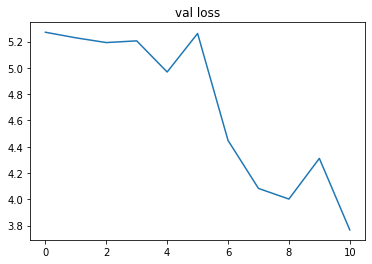

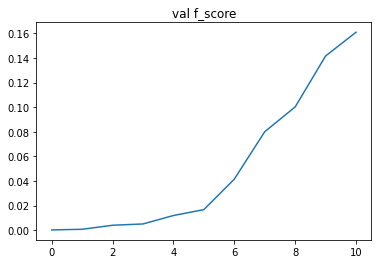

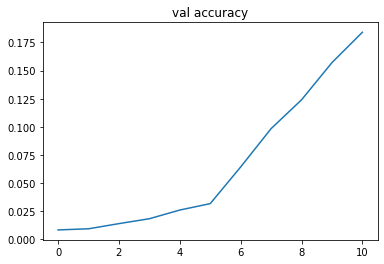

In [54]:
polt_history(torch_history_AdaBound)

In [21]:
# Pytorch official implementation + Adabound

torch_resnet101 = resnet101_torch(n_classes).to(device)

adam_torch = torch.optim.Adam(torch_resnet101.parameters(), lr = 0.001)

official_torch_history_Adam = {
    "train": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    },
    "val": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    }
} 

experiment_name = "official_torch_resnet_adam"

In [22]:
train_and_val(torch_resnet101, adam_torch, official_torch_history_Adam, experiment_name, n_train_epoches_in_iter = 4, n_iters = 10)

0
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:11<00:00,  4.67s/it]


train loss: 5.6942, f_score: 0.0008, accuracy: 0.004297642436149313
Epoch 2/4
----------


100%|██████████| 41/41 [03:06<00:00,  4.54s/it]


train loss: 5.3915, f_score: 0.0009, accuracy: 0.005771119842829076
Epoch 3/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 5.3295, f_score: 0.0006, accuracy: 0.008840864440078585
Epoch 4/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.43s/it]


train loss: 5.3047, f_score: 0.0006, accuracy: 0.00712180746561886
Epoch 1/1
----------


100%|██████████| 41/41 [01:43<00:00,  2.52s/it]


val loss: 5.6559, f_score: 0.0004, accuracy: 0.008456659619450317
1
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:05<00:00,  4.53s/it]


train loss: 5.2773, f_score: 0.0008, accuracy: 0.008595284872298626
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.44s/it]


train loss: 5.2529, f_score: 0.0015, accuracy: 0.007612966601178782
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.2176, f_score: 0.0034, accuracy: 0.01055992141453831
Epoch 4/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.43s/it]


train loss: 5.1463, f_score: 0.0046, accuracy: 0.013261296660117878
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 5.0550, f_score: 0.0062, accuracy: 0.02002238527546325
2
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 5.0564, f_score: 0.0088, accuracy: 0.01792730844793713
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 4.9507, f_score: 0.0145, accuracy: 0.02504911591355599
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 4.8471, f_score: 0.0172, accuracy: 0.027013752455795677
Epoch 4/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.48s/it]


train loss: 4.6772, f_score: 0.0272, accuracy: 0.03929273084479371
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.47s/it]


val loss: 4.5953, f_score: 0.0251, accuracy: 0.0481283422459893
3
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 4.5127, f_score: 0.0384, accuracy: 0.052676817288801574
Epoch 2/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 4.3203, f_score: 0.0521, accuracy: 0.0649557956777996
Epoch 3/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 4.1426, f_score: 0.0690, accuracy: 0.08300589390962672
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 3.9298, f_score: 0.0973, accuracy: 0.11137033398821218
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.47s/it]


val loss: 3.9785, f_score: 0.0852, accuracy: 0.11018530033577913
4
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.44s/it]


train loss: 3.7189, f_score: 0.1218, accuracy: 0.13740176817288802
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.44s/it]


train loss: 3.4805, f_score: 0.1588, accuracy: 0.17276522593320237
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.44s/it]


train loss: 3.2284, f_score: 0.2035, accuracy: 0.21414538310412573
Epoch 4/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.43s/it]


train loss: 3.0727, f_score: 0.2345, accuracy: 0.24226424361493124
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 3.5788, f_score: 0.1587, accuracy: 0.17933092898893171
5
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 2.8058, f_score: 0.2765, accuracy: 0.28462671905697445
Epoch 2/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 2.5673, f_score: 0.3288, accuracy: 0.33570726915520627
Epoch 3/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.43s/it]


train loss: 2.3197, f_score: 0.3827, accuracy: 0.38580550098231825
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 2.1442, f_score: 0.4158, accuracy: 0.4198182711198428
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 3.0974, f_score: 0.2475, accuracy: 0.2631513493346599
6
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 1.8991, f_score: 0.4773, accuracy: 0.47912573673870335
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 1.6707, f_score: 0.5290, accuracy: 0.531188605108055
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 1.5162, f_score: 0.5635, accuracy: 0.5654469548133595
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.44s/it]


train loss: 1.3282, f_score: 0.6175, accuracy: 0.618492141453831
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 2.6376, f_score: 0.3912, accuracy: 0.39771172739708993
7
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.43s/it]


train loss: 1.2374, f_score: 0.6445, accuracy: 0.6451375245579568
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 1.0649, f_score: 0.6873, accuracy: 0.6882367387033399
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 0.9347, f_score: 0.7237, accuracy: 0.7237229862475442
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 0.8541, f_score: 0.7479, accuracy: 0.7471758349705304
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.48s/it]


val loss: 3.6831, f_score: 0.4102, accuracy: 0.412510881731128
8
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.46s/it]


train loss: 0.7278, f_score: 0.7783, accuracy: 0.7781188605108055
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.44s/it]


train loss: 0.6677, f_score: 0.7994, accuracy: 0.7996070726915521
Epoch 3/4
----------


100%|██████████| 41/41 [03:01<00:00,  4.43s/it]


train loss: 0.6032, f_score: 0.8180, accuracy: 0.8179027504911591
Epoch 4/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.46s/it]


train loss: 0.5301, f_score: 0.8437, accuracy: 0.8430746561886051
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.47s/it]


val loss: 2.6827, f_score: 0.4403, accuracy: 0.44720805869916674
9
----------
Epoch 1/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 0.4445, f_score: 0.8606, accuracy: 0.8607563850687623
Epoch 2/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 0.4146, f_score: 0.8710, accuracy: 0.8708251473477406
Epoch 3/4
----------


100%|██████████| 41/41 [03:02<00:00,  4.45s/it]


train loss: 0.3812, f_score: 0.8811, accuracy: 0.881139489194499
Epoch 4/4
----------


100%|██████████| 41/41 [03:03<00:00,  4.47s/it]


train loss: 0.3813, f_score: 0.8794, accuracy: 0.8801571709233792
Epoch 1/1
----------


100%|██████████| 41/41 [01:41<00:00,  2.47s/it]

val loss: 2.6538, f_score: 0.5023, accuracy: 0.5021763462255938


In [23]:
with open(f'{experiment_name}_history.pickle', 'wb') as f:
    pickle.dump(official_torch_history_Adam, f)

with open(f'{experiment_name}_history.pickle', 'rb') as f:
    official_torch_history_Adam = pickle.load(f)

torch.save(adam_torch.state_dict(), f'{experiment_name}_optimizer_state.pickle')

In [27]:
# with open('/kaggle/input/resnet-torch-official-adabound-history-pickle/torch_history_AdaBound.pickle', 'rb') as f:
#     torch_history_AdaBound = pickle.load(f)

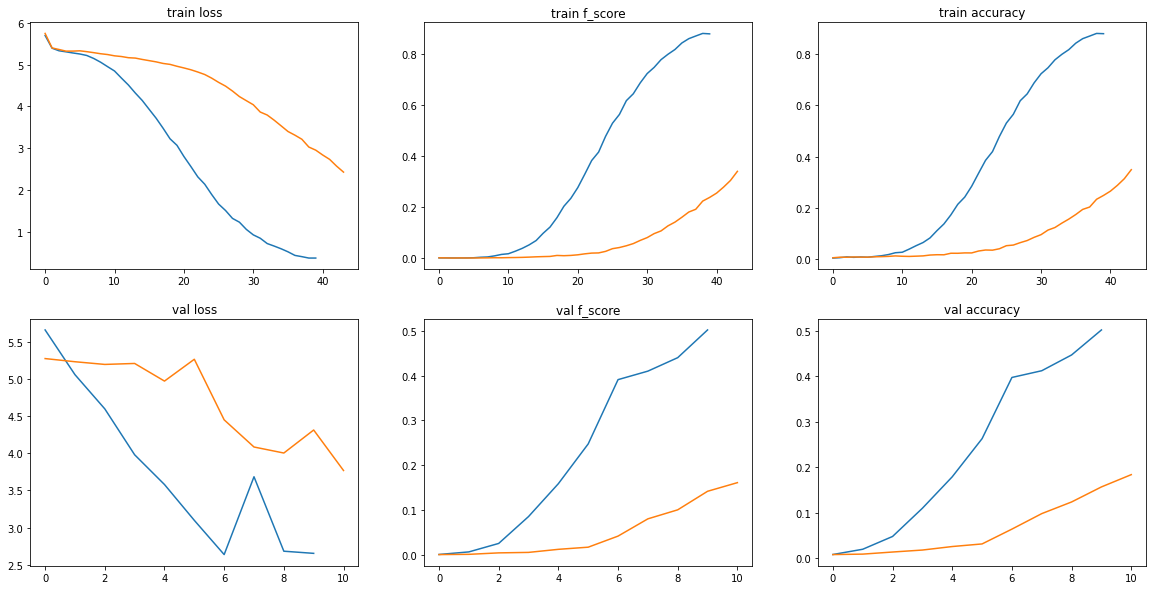

In [28]:
plot_history(official_torch_history_Adam, torch_history_AdaBound)

In [ ]:
S

In [6]:
# копипаста официального резнета с изменением числа каналов с 3 на 1 и удалением лишнего

from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torch
import torch.nn as nn
from torch import Tensor



def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    n_classes: int,
    weights,
    progress: bool,
    **kwargs: Any,
) -> ResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet(block, layers, n_classes, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))

    return model



# @register_model()
# @handle_legacy_interface(weights=("pretrained", ResNet18_Weights.IMAGENET1K_V1))
# def resnet18(*, weights: Optional[ResNet18_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
#     """ResNet-18 from `Deep Residual Learning for Image Recognition <https://arxiv.org/pdf/1512.03385.pdf>`__.

#     Args:
#         weights (:class:`~torchvision.models.ResNet18_Weights`, optional): The
#             pretrained weights to use. See
#             :class:`~torchvision.models.ResNet18_Weights` below for
#             more details, and possible values. By default, no pre-trained
#             weights are used.
#         progress (bool, optional): If True, displays a progress bar of the
#             download to stderr. Default is True.
#         **kwargs: parameters passed to the ``torchvision.models.resnet.ResNet``
#             base class. Please refer to the `source code
#             <https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py>`_
#             for more details about this class.

#     .. autoclass:: torchvision.models.ResNet18_Weights
#         :members:
#     """
#     weights = ResNet18_Weights.verify(weights)

#     return _resnet(BasicBlock, [2, 2, 2, 2], weights, progress, **kwargs)


# @register_model()
# @handle_legacy_interface(weights=("pretrained", ResNet34_Weights.IMAGENET1K_V1))
# def resnet34(*, weights: Optional[ResNet34_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
#     """ResNet-34 from `Deep Residual Learning for Image Recognition <https://arxiv.org/pdf/1512.03385.pdf>`__.

#     Args:
#         weights (:class:`~torchvision.models.ResNet34_Weights`, optional): The
#             pretrained weights to use. See
#             :class:`~torchvision.models.ResNet34_Weights` below for
#             more details, and possible values. By default, no pre-trained
#             weights are used.
#         progress (bool, optional): If True, displays a progress bar of the
#             download to stderr. Default is True.
#         **kwargs: parameters passed to the ``torchvision.models.resnet.ResNet``
#             base class. Please refer to the `source code
#             <https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py>`_
#             for more details about this class.

#     .. autoclass:: torchvision.models.ResNet34_Weights
#         :members:
#     """
#     weights = ResNet34_Weights.verify(weights)

#     return _resnet(BasicBlock, [3, 4, 6, 3], weights, progress, **kwargs)


# @register_model()
# @handle_legacy_interface(weights=("pretrained", ResNet50_Weights.IMAGENET1K_V1))
# def resnet50(*, weights: Optional[ResNet50_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
#     """ResNet-50 from `Deep Residual Learning for Image Recognition <https://arxiv.org/pdf/1512.03385.pdf>`__.

#     .. note::
#        The bottleneck of TorchVision places the stride for downsampling to the second 3x3
#        convolution while the original paper places it to the first 1x1 convolution.
#        This variant improves the accuracy and is known as `ResNet V1.5
#        <https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch>`_.

#     Args:
#         weights (:class:`~torchvision.models.ResNet50_Weights`, optional): The
#             pretrained weights to use. See
#             :class:`~torchvision.models.ResNet50_Weights` below for
#             more details, and possible values. By default, no pre-trained
#             weights are used.
#         progress (bool, optional): If True, displays a progress bar of the
#             download to stderr. Default is True.
#         **kwargs: parameters passed to the ``torchvision.models.resnet.ResNet``
#             base class. Please refer to the `source code
#             <https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py>`_
#             for more details about this class.

#     .. autoclass:: torchvision.models.ResNet50_Weights
#         :members:
#     """
#     weights = ResNet50_Weights.verify(weights)

#     return _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)


def resnet101_torch(n_classes, progress: bool = True, **kwargs: Any) -> ResNet:
    weights = None
    return _resnet(Bottleneck, [3, 4, 23, 3], n_classes, weights, progress, **kwargs)



# @register_model()
# @handle_legacy_interface(weights=("pretrained", ResNet101_Weights.IMAGENET1K_V1))
# def resnet101(*, weights: Optional[ResNet101_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
#     """ResNet-101 from `Deep Residual Learning for Image Recognition <https://arxiv.org/pdf/1512.03385.pdf>`__.

#     .. note::
#        The bottleneck of TorchVision places the stride for downsampling to the second 3x3
#        convolution while the original paper places it to the first 1x1 convolution.
#        This variant improves the accuracy and is known as `ResNet V1.5
#        <https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch>`_.

#     Args:
#         weights (:class:`~torchvision.models.ResNet101_Weights`, optional): The
#             pretrained weights to use. See
#             :class:`~torchvision.models.ResNet101_Weights` below for
#             more details, and possible values. By default, no pre-trained
#             weights are used.
#         progress (bool, optional): If True, displays a progress bar of the
#             download to stderr. Default is True.
#         **kwargs: parameters passed to the ``torchvision.models.resnet.ResNet``
#             base class. Please refer to the `source code
#             <https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py>`_
#             for more details about this class.

#     .. autoclass:: torchvision.models.ResNet101_Weights
#         :members:
#     """
#     weights = ResNet101_Weights.verify(weights)

#     return _resnet(Bottleneck, [3, 4, 23, 3], weights, progress, **kwargs)


# @register_model()
# @handle_legacy_interface(weights=("pretrained", ResNeXt50_32X4D_Weights.IMAGENET1K_V1))
# def resnext50_32x4d(
#     *, weights: Optional[ResNeXt50_32X4D_Weights] = None, progress: bool = True, **kwargs: Any
# ) -> ResNet:
#     """ResNeXt-50 32x4d model from
#     `Aggregated Residual Transformation for Deep Neural Networks <https://arxiv.org/abs/1611.05431>`_.

#     Args:
#         weights (:class:`~torchvision.models.ResNeXt50_32X4D_Weights`, optional): The
#             pretrained weights to use. See
#             :class:`~torchvision.models.ResNext50_32X4D_Weights` below for
#             more details, and possible values. By default, no pre-trained
#             weights are used.
#         progress (bool, optional): If True, displays a progress bar of the
#             download to stderr. Default is True.
#         **kwargs: parameters passed to the ``torchvision.models.resnet.ResNet``
#             base class. Please refer to the `source code
#             <https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py>`_
#             for more details about this class.
#     .. autoclass:: torchvision.models.ResNeXt50_32X4D_Weights
#         :members:
#     """
#     weights = ResNeXt50_32X4D_Weights.verify(weights)

#     _ovewrite_named_param(kwargs, "groups", 32)
#     _ovewrite_named_param(kwargs, "width_per_group", 4)
#     return _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)


# @register_model()
# @handle_legacy_interface(weights=("pretrained", ResNeXt101_32X8D_Weights.IMAGENET1K_V1))
# def resnext101_32x8d(
#     *, weights: Optional[ResNeXt101_32X8D_Weights] = None, progress: bool = True, **kwargs: Any
# ) -> ResNet:
#     """ResNeXt-101 32x8d model from
#     `Aggregated Residual Transformation for Deep Neural Networks <https://arxiv.org/abs/1611.05431>`_.

#     Args:
#         weights (:class:`~torchvision.models.ResNeXt101_32X8D_Weights`, optional): The
#             pretrained weights to use. See
#             :class:`~torchvision.models.ResNeXt101_32X8D_Weights` below for
#             more details, and possible values. By default, no pre-trained
#             weights are used.
#         progress (bool, optional): If True, displays a progress bar of the
#             download to stderr. Default is True.
#         **kwargs: parameters passed to the ``torchvision.models.resnet.ResNet``
#             base class. Please refer to the `source code
#             <https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py>`_
#             for more details about this class.
#     .. autoclass:: torchvision.models.ResNeXt101_32X8D_Weights
#         :members:
#     """
#     weights = ResNeXt101_32X8D_Weights.verify(weights)

#     _ovewrite_named_param(kwargs, "groups", 32)
#     _ovewrite_named_param(kwargs, "width_per_group", 8)
#     return _resnet(Bottleneck, [3, 4, 23, 3], weights, progress, **kwargs)


# @register_model()
# @handle_legacy_interface(weights=("pretrained", ResNeXt101_64X4D_Weights.IMAGENET1K_V1))
# def resnext101_64x4d(
#     *, weights: Optional[ResNeXt101_64X4D_Weights] = None, progress: bool = True, **kwargs: Any
# ) -> ResNet:
#     """ResNeXt-101 64x4d model from
#     `Aggregated Residual Transformation for Deep Neural Networks <https://arxiv.org/abs/1611.05431>`_.

#     Args:
#         weights (:class:`~torchvision.models.ResNeXt101_64X4D_Weights`, optional): The
#             pretrained weights to use. See
#             :class:`~torchvision.models.ResNeXt101_64X4D_Weights` below for
#             more details, and possible values. By default, no pre-trained
#             weights are used.
#         progress (bool, optional): If True, displays a progress bar of the
#             download to stderr. Default is True.
#         **kwargs: parameters passed to the ``torchvision.models.resnet.ResNet``
#             base class. Please refer to the `source code
#             <https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py>`_
#             for more details about this class.
#     .. autoclass:: torchvision.models.ResNeXt101_64X4D_Weights
#         :members:
#     """
#     weights = ResNeXt101_64X4D_Weights.verify(weights)

#     _ovewrite_named_param(kwargs, "groups", 64)
#     _ovewrite_named_param(kwargs, "width_per_group", 4)
#     return _resnet(Bottleneck, [3, 4, 23, 3], weights, progress, **kwargs)


# @register_model()
# @handle_legacy_interface(weights=("pretrained", Wide_ResNet50_2_Weights.IMAGENET1K_V1))
# def wide_resnet50_2(
#     *, weights: Optional[Wide_ResNet50_2_Weights] = None, progress: bool = True, **kwargs: Any
# ) -> ResNet:
#     """Wide ResNet-50-2 model from
#     `Wide Residual Networks <https://arxiv.org/abs/1605.07146>`_.

#     The model is the same as ResNet except for the bottleneck number of channels
#     which is twice larger in every block. The number of channels in outer 1x1
#     convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
#     channels, and in Wide ResNet-50-2 has 2048-1024-2048.

#     Args:
#         weights (:class:`~torchvision.models.Wide_ResNet50_2_Weights`, optional): The
#             pretrained weights to use. See
#             :class:`~torchvision.models.Wide_ResNet50_2_Weights` below for
#             more details, and possible values. By default, no pre-trained
#             weights are used.
#         progress (bool, optional): If True, displays a progress bar of the
#             download to stderr. Default is True.
#         **kwargs: parameters passed to the ``torchvision.models.resnet.ResNet``
#             base class. Please refer to the `source code
#             <https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py>`_
#             for more details about this class.
#     .. autoclass:: torchvision.models.Wide_ResNet50_2_Weights
#         :members:
#     """
#     weights = Wide_ResNet50_2_Weights.verify(weights)

#     _ovewrite_named_param(kwargs, "width_per_group", 64 * 2)
#     return _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)


# @register_model()
# @handle_legacy_interface(weights=("pretrained", Wide_ResNet101_2_Weights.IMAGENET1K_V1))
# def wide_resnet101_2(
#     *, weights: Optional[Wide_ResNet101_2_Weights] = None, progress: bool = True, **kwargs: Any
# ) -> ResNet:
#     """Wide ResNet-101-2 model from
#     `Wide Residual Networks <https://arxiv.org/abs/1605.07146>`_.

#     The model is the same as ResNet except for the bottleneck number of channels
#     which is twice larger in every block. The number of channels in outer 1x1
#     convolutions is the same, e.g. last block in ResNet-101 has 2048-512-2048
#     channels, and in Wide ResNet-101-2 has 2048-1024-2048.

#     Args:
#         weights (:class:`~torchvision.models.Wide_ResNet101_2_Weights`, optional): The
#             pretrained weights to use. See
#             :class:`~torchvision.models.Wide_ResNet101_2_Weights` below for
#             more details, and possible values. By default, no pre-trained
#             weights are used.
#         progress (bool, optional): If True, displays a progress bar of the
#             download to stderr. Default is True.
#         **kwargs: parameters passed to the ``torchvision.models.resnet.ResNet``
#             base class. Please refer to the `source code
#             <https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py>`_
#             for more details about this class.
#     .. autoclass:: torchvision.models.Wide_ResNet101_2_Weights
#         :members:
#     """
#     weights = Wide_ResNet101_2_Weights.verify(weights)

#     _ovewrite_named_param(kwargs, "width_per_group", 64 * 2)
#     return _resnet(Bottleneck, [3, 4, 23, 3], weights, progress, **kwargs)


# # The dictionary below is internal implementation detail and will be removed in v0.15
# from ._utils import _ModelURLs


# model_urls = _ModelURLs(
#     {
#         "resnet18": ResNet18_Weights.IMAGENET1K_V1.url,
#         "resnet34": ResNet34_Weights.IMAGENET1K_V1.url,
#         "resnet50": ResNet50_Weights.IMAGENET1K_V1.url,
#         "resnet101": ResNet101_Weights.IMAGENET1K_V1.url,
#         "resnet152": ResNet152_Weights.IMAGENET1K_V1.url,
#         "resnext50_32x4d": ResNeXt50_32X4D_Weights.IMAGENET1K_V1.url,
#         "resnext101_32x8d": ResNeXt101_32X8D_Weights.IMAGENET1K_V1.url,
#         "wide_resnet50_2": Wide_ResNet50_2_Weights.IMAGENET1K_V1.url,
#         "wide_resnet101_2": Wide_ResNet101_2_Weights.IMAGENET1K_V1.url,
#     }
# )

In [7]:
# import math
# import torch
# from torch.optim import Optimizer


# class AdaBound(Optimizer):
#     # source: https://github.com/Luolc/AdaBound
#     """Implements AdaBound algorithm.
#     It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
#     Arguments:
#         params (iterable): iterable of parameters to optimize or dicts defining
#             parameter groups
#         lr (float, optional): Adam learning rate (default: 1e-3)
#         betas (Tuple[float, float], optional): coefficients used for computing
#             running averages of gradient and its square (default: (0.9, 0.999))
#         final_lr (float, optional): final (SGD) learning rate (default: 0.1)
#         gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
#         eps (float, optional): term added to the denominator to improve
#             numerical stability (default: 1e-8)
#         weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
#         amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
#     .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
#         https://openreview.net/forum?id=Bkg3g2R9FX
#     """

#     def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
#                  eps=1e-8, weight_decay=0, amsbound=False):
#         if not 0.0 <= lr:
#             raise ValueError("Invalid learning rate: {}".format(lr))
#         if not 0.0 <= eps:
#             raise ValueError("Invalid epsilon value: {}".format(eps))
#         if not 0.0 <= betas[0] < 1.0:
#             raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
#         if not 0.0 <= betas[1] < 1.0:
#             raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
#         if not 0.0 <= final_lr:
#             raise ValueError("Invalid final learning rate: {}".format(final_lr))
#         if not 0.0 <= gamma < 1.0:
#             raise ValueError("Invalid gamma parameter: {}".format(gamma))
#         defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
#                         weight_decay=weight_decay, amsbound=amsbound)
#         super(AdaBound, self).__init__(params, defaults)

#         self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

#     def __setstate__(self, state):
#         super(AdaBound, self).__setstate__(state)
#         for group in self.param_groups:
#             group.setdefault('amsbound', False)

#     def step(self, closure=None):
#         """Performs a single optimization step.
#         Arguments:
#             closure (callable, optional): A closure that reevaluates the model
#                 and returns the loss.
#         """
#         loss = None
#         if closure is not None:
#             loss = closure()

#         for group, base_lr in zip(self.param_groups, self.base_lrs):
#             for p in group['params']:
#                 if p.grad is None:
#                     continue
#                 grad = p.grad.data
#                 if grad.is_sparse:
#                     raise RuntimeError(
#                         'Adam does not support sparse gradients, please consider SparseAdam instead')
#                 amsbound = group['amsbound']

#                 state = self.state[p]

#                 # State initialization
#                 if len(state) == 0:
#                     state['step'] = 0
#                     # Exponential moving average of gradient values
#                     state['exp_avg'] = torch.zeros_like(p.data)
#                     # Exponential moving average of squared gradient values
#                     state['exp_avg_sq'] = torch.zeros_like(p.data)
#                     if amsbound:
#                         # Maintains max of all exp. moving avg. of sq. grad. values
#                         state['max_exp_avg_sq'] = torch.zeros_like(p.data)

#                 exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
#                 if amsbound:
#                     max_exp_avg_sq = state['max_exp_avg_sq']
#                 beta1, beta2 = group['betas']

#                 state['step'] += 1

#                 if group['weight_decay'] != 0:
#                     grad = grad.add(group['weight_decay'], p.data)

#                 # Decay the first and second moment running average coefficient
#                 exp_avg.mul_(beta1).add_(1 - beta1, grad)
#                 exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
#                 if amsbound:
#                     # Maintains the maximum of all 2nd moment running avg. till now
#                     torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
#                     # Use the max. for normalizing running avg. of gradient
#                     denom = max_exp_avg_sq.sqrt().add_(group['eps'])
#                 else:
#                     denom = exp_avg_sq.sqrt().add_(group['eps'])

#                 bias_correction1 = 1 - beta1 ** state['step']
#                 bias_correction2 = 1 - beta2 ** state['step']
#                 step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

#                 # Applies bounds on actual learning rate
#                 # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
#                 final_lr = group['final_lr'] * group['lr'] / base_lr
#                 lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
#                 upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
#                 step_size = torch.full_like(denom, step_size)
#                 step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

#                 p.data.add_(-step_size)

#         return loss

In [ ]:
import math
import torch
from torch.optim import Optimizer


class AdaBound(Optimizer):
    # source: https://github.com/Luolc/AdaBound
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                
                
                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss